# Reinforcement Learning Solution to the Towers of Hanoi Puzzle

Name: __Luke Burford__

For this assignment, you will use reinforcement learning to solve the [Towers of Hanoi](https://en.wikipedia.org/wiki/Tower_of_Hanoi) puzzle.  

To accomplish this, you must modify the code discussed in lecture for learning to play Tic-Tac-Toe.  Modify the code  so that it learns to solve the three-disk, three-peg
Towers of Hanoi Puzzle.  In some ways, this will be simpler than the
Tic-Tac-Toe code.  

Steps required to do this include the following:

  - Represent the state, and use it as a tuple as a key to the Q dictionary.
  - Make sure only valid moves are tried from each state.
  - Assign reinforcement of $1$ to each move, even for the move that results in the goal state.

Make a plot of the number of steps required to reach the goal for each
trial.  Each trial starts from the same initial state.  Decay epsilon
as in the Tic-Tac-Toe code.

## Requirements

First, how should we represent the state of this puzzle?  We need to keep track of which disks are on which pegs. Name the disks 1, 2, and 3, with 1 being the smallest disk and 3 being the largest. The set of disks on a peg can be represented as a list of integers.  Then the state can be a list of three lists.

For example, the starting state with all disks being on the left peg would be `[[1, 2, 3], [], []]`.  After moving disk 1 to peg 2, we have `[[2, 3], [1], []]`.

To represent that move we just made, we can use a list of two peg numbers, like `[1, 2]`, representing a move of the top disk on peg 1 to peg 2.

Now on to some functions. Define at least the following functions. Examples showing required output appear below.

   - `printState(state)`: prints the state in the form shown below
   - `validMoves(state)`: returns list of moves that are valid from `state`
   - `makeMove(state, move)`: returns new (copy of) state after move has been applied.
   - `trainQ(nRepetitions, learningRate, epsilonDecayFactor, validMovesF, makeMoveF)`: train the Q function for number of repetitions, decaying epsilon at start of each repetition. Returns Q and list or array of number of steps to reach goal for each repetition.
   - `testQ(Q, maxSteps, validMovesF, makeMoveF)`: without updating Q, use Q to find greedy action each step until goal is found. Return path of states.

A function that you might choose to implement is

   - `stateMoveTuple(state, move)`: returns tuple of state and move.  
    
This is useful for converting state and move to a key to be used for the Q dictionary.

Show the code and results for testing each function.  Then experiment with various values of `nRepetitions`, `learningRate`, and `epsilonDecayFactor` to find values that work reasonably well, meaning that eventually the minimum solution path of seven steps is found consistently.

Make a plot of the number of steps in the solution path versus number of repetitions. The plot should clearly show the number of steps in the solution path eventually reaching the minimum of seven steps, though the decrease will not be monotonic.  Also plot a horizontal, dashed line at 7 to show the optimal path length.

Add markdown cells in which you describe the Q learning algorithm and your implementation of Q learning as applied to the Towers of Hanoi problem.  Use at least 15 sentences, in one or more markdown cells.

## __Helper Functions:__

The following functions are used to complete the tower of Hanoi puzzle. These functions  were copied from the A4 assignment. The functions declarations are:

   - `printState(state)`: prints the state in the form shown below.
   - `validMoves(state)`: returns list of moves that are valid from `state`.
   - `makeMove(state, move)`: returns new (copy of) state after move has been applied.
   - `trainQ(nRepetitions, learningRate, epsilonDecayFactor, validMovesF, makeMoveF)`: train the Q function for number of repetitions, decaying epsilon at start of each repetition. Returns Q and list or array of number of steps to reach goal for each repetition.
   - `testQ(Q, maxSteps, validMovesF, makeMoveF)`: without updating Q, use Q to find greedy action each step until goal is found. Return path of states.
   - `stateMoveTuple(state, move)`: returns tuple of state and move.

In [104]:
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, clear_output

**`printState(state)`**: prints the state in the form shown below.

In [105]:
def printState(state):
    #Check for the three conditions: peg has 3 disks, peg has 2 and one has 1, each peg has 3 disks
    unique = True
    for i in range(3):
        currPeg = state[i]
        if len(currPeg) is 3:
            if i is 0:
                print(str(currPeg[0]) + "\n" + str(currPeg[1]) + "\n" + str(currPeg[2]) + "\n------")
            elif i is 1:
                print("  " + str(currPeg[0]) + "\n  " + str(currPeg[1]) + "\n  " + str(currPeg[2]) + "\n------")
            else:
                print("    " + str(currPeg[0]) + "\n    " + str(currPeg[1]) + "\n    " + str(currPeg[2]) + "\n------")
            return
        elif len(currPeg) is 2:
            unique = False
            
    #peg has 1 disk:
    if unique:
        for currPeg in state:
            print(currPeg[0], end = " ")
        print("")
    #peg has 2, another has 1:
    else:
        for row in range(2):
            for currPeg in state:
                if len(currPeg) is 2 and row is 0:
                    print(str(currPeg[0]), end = " ")
                elif len(currPeg) is 2:
                    print(str(currPeg[1]), end = " ")
                elif len(currPeg) is 1 and row is 1:
                    print(currPeg[0], end = " ")
                else:
                    print(" ", end = " ")
            print("")
    print("------")  

printState(state) tests:

In [106]:
state = [[1, 2, 3], [], []]
printState(state)

1
2
3
------


In [107]:
state = [[1], [], [2, 3]]
printState(state)

    2 
1   3 
------


In [108]:
state = [[1], [2], [3]]
printState(state)

1 2 3 
------


In [109]:
state = [[], [1], [2,3]]
printState(state)

    2 
  1 3 
------


In [110]:
state = [[], [], [1,2,3]]
printState(state)

    1
    2
    3
------


printState is printing correctly

**`validMoves(state)`**: returns list of moves that are valid from `state`.

In [133]:
def validMoves(state):
    moves = []
    for i in range(3):
        currP = state[i]
        if len(currP) is not 0:
            top = currP[0]
            for j in range(3):
                if i == j:
                    continue
                newP = state[j]
                if len(newP) is 0:
                    moves.append([i+1,j+1])
                else:
                    newT = newP[0]
                    if top < newT:
                        moves.append([i+1,j+1])
    return moves

validMoves(state) tests:

In [112]:
state = [[1, 2, 3], [], []]
validMoves(state)

[[1, 2], [1, 3]]

In [113]:
state = [[1, 2], [], [3]]
validMoves(state)

[[1, 2], [1, 3], [3, 2]]

In [114]:
state = [[3, 2], [], [1]]
validMoves(state)

[[1, 2], [3, 1], [3, 2]]

validMoves seems to be working accordingly


**`makeMove(state, move)`**: returns new (copy of) state after move has been applied.

In [115]:
def makeMove(state, move):
    newState = deepcopy(state)
    #Subtract one from each value in move to convert back to index
    iFrom = move[0]-1
    iTo = move[1]-1
    #Always move the top disk, so whatever is at front of list at iFrom
    disk = newState[iFrom][0]
    #Remove disk from iFrom
    newState[iFrom].remove(disk)
    #Add disk to iTo
    newState[iTo].insert(0, disk)
    return newState

makeMove(state, move) tests:

In [116]:
state = [[1, 2, 3], [], []]
validMoves(state)

[[1, 2], [1, 3]]

In [117]:
newState = makeMove(state, [1,2,3])
printState(state)
printState(newState)

1
2
3
------
2     
3 1   
------


In [118]:
newState = makeMove(state, [1,2])
printState(state)
printState(newState)
state = newState

1
2
3
------
2     
3 1   
------


In [119]:
validMoves(state)

[[1, 3], [2, 1], [2, 3]]

In [120]:
newState = makeMove(state, [1,3,2])
printState(state)
printState(newState)

2     
3 1   
------
3 1 2 
------


validMoves is checking moves correctly

In [121]:
def stateMoveTuple(state, move):
    first = tuple(state[0])
    second = tuple(state[1])
    third = tuple(state[2])
    tMove = tuple(move)
    SMT = ((first, second, third), tMove)
    return SMT

stateMoveTuple(state, move) tests:

In [122]:
state = [[1, 2, 3], [], []]
move =[1, 3]
stateMoveTuple(state, move)

(((1, 2, 3), (), ()), (1, 3))

In [123]:
state = [[1], [2], [3]]
move =[1, 2]
stateMoveTuple(state, move)

(((1,), (2,), (3,)), (1, 2))

In [124]:
state = [[], [2, 3], [1]]
move =[2, 3]
stateMoveTuple(state, move)

(((), (2, 3), (1,)), (2, 3))

stateMoveTuple is working correctly

## Q Table

The following functions initialize the Q table, creates training functions, and creates learning params. These functions are all based off of example code given in class.

##  Describing the Q learning algorithm:

The Q learning algorithm is a reinforcement learning technique. Its goal is to learn a policy which tells an agent what action to take under certain circumstances. It should be noted it does not need a model of the enviroment and can handle problems without requiring adaptations. At its simplest stores data in a table.

In [125]:
def epsilonGreedy(epsilon, Q, state, validMovesF):
    posMoves = validMovesF(state)
    if np.random.uniform() < epsilon:
        rand = np.random.randint(len(posMoves)-1)
        return posMoves[rand]
    else:
        Qs = np.array([Q.get(stateMoveTuple(state, m), 0) for m in posMoves]) 
        return posMoves[np.argmin(Qs)]

Training Functions:

In [126]:
epsilonDecayFactor = 0.99
learningRate = 0.25
nRepetitions = 50000

**`plotOutcomes(numSteps, nRepetitions, rep)`**: plots the result of the trainQ function into a readable chart.

In [127]:
def plotOutcomes(numSteps, nRepetitions, rep):
    if rep==0:
        return
    nBins = 100
    nPer = int(nRepetitions/nBins)
    
    avgs = [sum(numSteps[i:i+nPer])//nPer for i in range(0, len(numSteps), nPer)]
    if len(avgs) > 2:
        avgs.pop()
        avgs.append(avgs[-1])
    
    plt.subplot(1,1,1) 
    xs = np.linspace(nPer,rep,len(avgs))
    plt.plot(xs, avgs)
    plt.xlabel('Repetitions')
    plt.ylabel('Mean of Number of Steps \nto Solution (ideal is 7)')
    plt.title('Bins of {:d} Repetitions'.format(nPer))
    plt.axhline(y=7, color = 'r', linestyle='--')

**`trainQ(nRepetitions, learningRate, epsilonDecayFactor, validMovesF, makeMoveF)`**: train the Q function for number of repetitions, decaying epsilon at start of each repetition. Returns Q and list or array of number of steps to reach goal for each repetition.

In [128]:
def trainQ(nRepetitions, learningRate, epsilonDecayFactor, validMovesF, makeMoveF):
    Q = {}
    numSteps = []
    epsilon = 1.0
    # this needs to be set to true in order to see the charts plotted
    graphics = False
    if graphics:
        fig = plt.figure(figsize=(10,10))
    
    for rep in range(nRepetitions):
        epsilon *= epsilonDecayFactor
        step = 0
        state = [[1,2,3],[],[]]
        done = False
        
        while not done:
            step += 1
            #find next move:
            move = epsilonGreedy(epsilon, Q, state, validMovesF)
            #take next move:
            newS = makeMoveF(state, move)
            #add to Q table
            currSMT = stateMoveTuple(state,move)
            if currSMT not in Q:
                Q[currSMT] = 0
            
            if step > 1:
                prevSMT = stateMoveTuple(oldS, oldM)
                #check if puzzle has been solved:
                if newS == [[],[],[1,2,3]]:
                    done = True
                    Q[prevSMT] = 1
                    numSteps.append(step)
                else:  
                    Q[prevSMT] += learningRate * (1 + Q[currSMT] - Q[prevSMT])
            
            oldS, oldM = state, move 
            state = newS
    
        if graphics and (rep % (nRepetitions/10) == 0 or rep == nRepetitions-1):
            fig.clf()
            plotOutcomes(numSteps,nRepetitions,rep-1)
            clear_output(wait=True)
            display(fig);
        
    if graphics:
        clear_output(wait=True)
    return Q, numSteps

`plotOutcomes(numSteps, nRepetitions, rep)` and `trainQ(nRepetitions, learningRate, epsilonDecayFactor, validMovesF, makeMoveF)` tests:

**NOTE:** In order to plot the charts I suggest to comment out the return of trainQ and set the graphics boolean to true in order to properly see what I am commenting on in the markdown. But leaving the graphics boolean true breaks the auto grader, sorry for the inconvience.

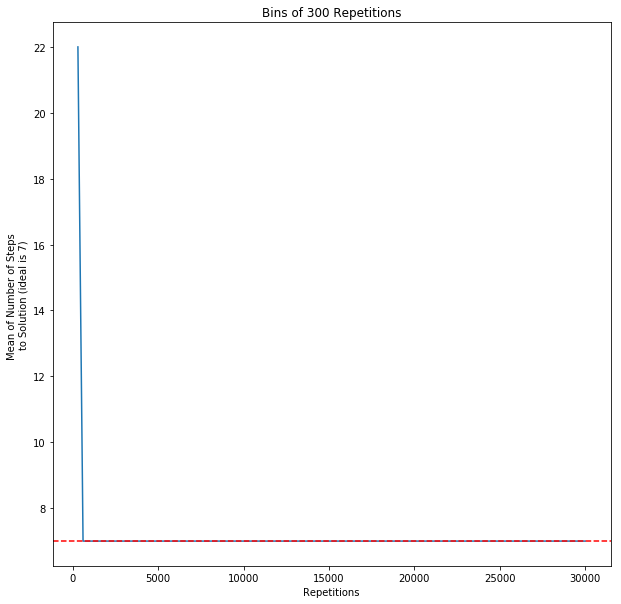

In [45]:
epsilonDecayFactor = 0.99
learningRate = 0.25 #same as rho
nRepetitions = 30000
graphics = True
trainQ(nRepetitions, learningRate, epsilonDecayFactor, validMoves, makeMove)

This chart shows that it meets the ideal number of steps quickly. However this is not always consitent. This could possible be caused by the learning rate being too high; it is just as likely to converge on step 7 as it does on step 8.

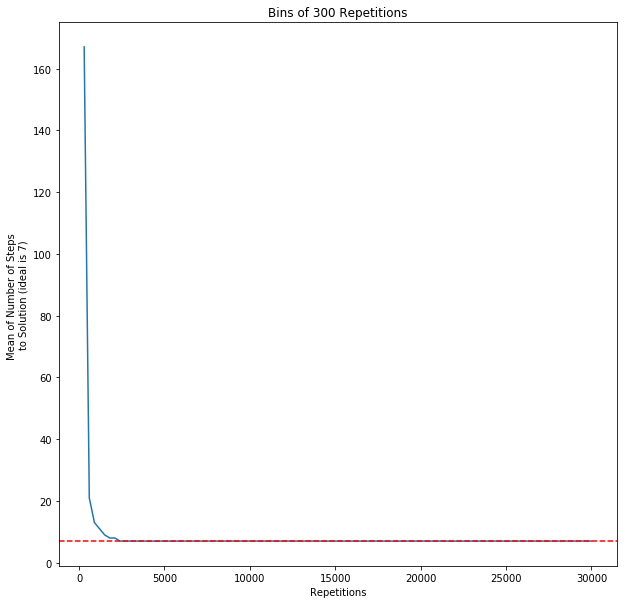

In [46]:
epsilonDecayFactor = 0.999
learningRate = 0.10 #same as rho
nRepetitions = 30000
graphics = True
trainQ(nRepetitions, learningRate, epsilonDecayFactor, validMoves, makeMove)

This one works better. When looking at 8 steps in the solution path there is an uncertainty, and then able to find the ideal 7 step solution. 

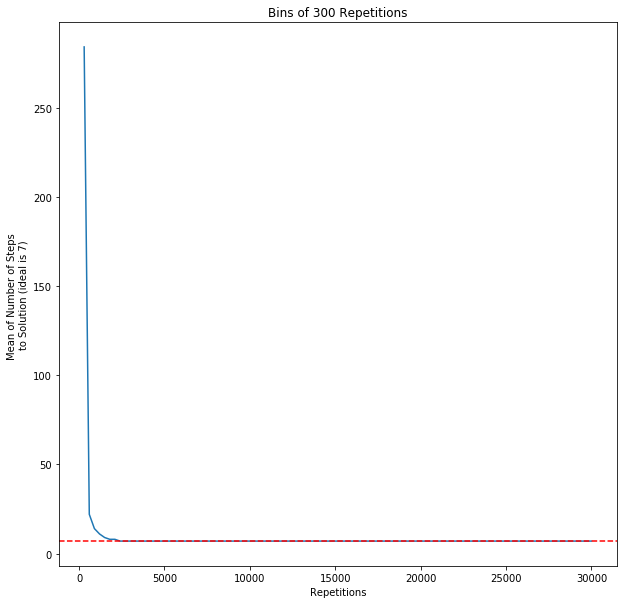

In [47]:
epsilonDecayFactor = 0.999
learningRate = 0.02 #same as rho
nRepetitions = 30000
graphics = True
trainQ(nRepetitions, learningRate, epsilonDecayFactor, validMoves, makeMove)

This result is also a consistent, correct solution path that is found quickly. There is a lot of fine tuning that can be done. `learningRate` and `epsilonDecayFactor` seem to provide very consistent results.

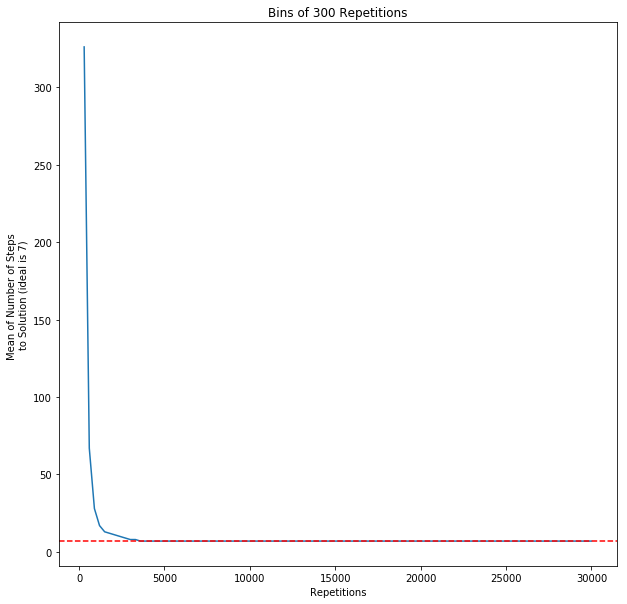

In [48]:
epsilonDecayFactor = 0.999
learningRate = 0.002 #same as rho
nRepetitions = 30000
graphics = True
trainQ(nRepetitions, learningRate, epsilonDecayFactor, validMoves, makeMove)

With these values of `learningRate` and `epsilonDecayFactor`, the min sol path of 7 is found in 10k-15k iterations. It should be noted that `learningRate = 0.2` decreases the number of iterations necessary while not sacrificing accuracy.

# Examples

In [129]:
def testQ(Q, maxSteps, validMovesF, makeMoveF):
    state = [[1,2,3],[],[]]
    path = []
    step = 0
    while(step <= maxSteps):
        step += 1
        poss = validMovesF(state)
        Qs = np.array([Q.get(stateMoveTuple(state, m), 0) for m in poss])
        nextM = poss[np.argmin(Qs)]
        path.append(nextM)
        state = makeMoveF(state, nextM)
        if state == [[],[],[1,2,3]]:
            return path
    return path   

`testQ(Q, maxSteps, validMovesF, makeMoveF)` tests:

In [90]:
Q, steps = trainQ(1000, 0.5, 0.7, validMoves, makeMove)

In [91]:
path = testQ(Q, 20, validMoves, makeMove)

In [92]:
path

[[1, 3], [1, 2], [3, 2], [1, 3], [2, 1], [2, 3], [1, 3]]

**Provided Examples**:

In [93]:
state = [[1, 2, 3], [], []]
printState(state)

1
2
3
------


In [94]:
validMoves(state)

[[1, 2], [1, 3]]

In [95]:
move =[1, 2]

stateMoveTuple(state, move)

(((1, 2, 3), (), ()), (1, 2))

In [96]:
newstate = makeMove(state, move)
newstate

[[2, 3], [1], []]

In [97]:
printState(newstate)

2     
3 1   
------


In [98]:
Q, stepsToGoal = trainQ(50, 0.5, 0.7, validMoves, makeMove)

In [99]:
stepsToGoal

[152,
 94,
 102,
 17,
 25,
 16,
 29,
 12,
 21,
 8,
 13,
 7,
 15,
 7,
 7,
 23,
 7,
 10,
 7,
 23,
 9,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7]

In [100]:
path = testQ(Q, 20, validMoves, makeMove)

In [101]:
path

[[1, 3], [1, 2], [3, 2], [1, 3], [2, 1], [2, 3], [1, 3]]